# PHYS 321 Coding Lab #7: Markov Chain Monte Carlo

In this coding lab, we apply the technique of Markov Chain Monte Carlo (MCMC) sampling to sample several posterior distributions.

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Install the ``corner`` package

We'll need the ``corner`` Python package to help us make pretty triangle/corner plots. Try running the command ``import corner``. If you get an error, fire up your terminal and execute ``conda install corner``.

In [2]:
import corner

## Redoing the cake selling problem with MCMCs

As a warm-up, we will redo the cake-selling problem from the Coding Midterm. Reducing the problem to its mathematical barebones, recall that we have measured six numbers $n=6, 6, 8, 8, 6, 8$ that are drawn independently from a Poisson distribution:

\begin{equation}
p(n) = \frac{e^{-\lambda} \lambda^n}{n!}
\end{equation}

We don't know the rate parameter $\lambda$, and we would like to infer it from the data. Bayes' theorem tells us

\begin{equation}
p(\lambda | n_1, n_2, \dots , n_6) \propto p(n_1, n_2, \dots , n_6 | \lambda ) p (\lambda)
\end{equation}
and the likelihood function is given by

\begin{equation}
p(n_1, n_2, \dots , n_6 | \lambda ) = \prod_{i=1}^6 p(n_i | \lambda) = \prod_{i=1}^6 \frac{e^{-\lambda}\lambda^{n_i}}{n_i !}.
\end{equation}

Adopting a uniform prior between $\lambda =0$ and $\lambda = 15$, one obtains the following posterior distribution for $\lambda$:
<div>
<img src="images/cakes_posterior.png" width="400">
</div>
With just one parameter (and therefore a one-dimensional parameter space), it is computationally feasible to just plot the posterior by brute force evaluation. But as a warmup for the other exercises in this Coding Lab, let's also solve this problem using MCMCs.

Recall that the Metropolis algorithm for MCMC sampling goes as follows:
1. Starting at some point $\boldsymbol{\theta}^{(n)}$ in parameter space...
2. Propose a step to a new location by drawing randomly from the proposal distribution $q(\boldsymbol{\theta}^\prime | \boldsymbol{\theta}^{(n)})$, e.g., $q(\boldsymbol{\theta}^\prime | \boldsymbol{\theta}^{(n)}) \propto \exp\left[ - \frac{|\boldsymbol{\theta}^\prime - \boldsymbol{\theta}^{(n)}|^2}{2 \eta^2}\right]$
3. Draw a random number $r$ from a uniform distribution over $0<r<1$.
4. If $\frac{p(\boldsymbol{\theta}^\prime | \textrm{data})}{p(\boldsymbol{\theta}^{(n)} | \textrm{data})} > r$, then accept the step and call $\boldsymbol{\theta}^{(n+1)} = \boldsymbol{\theta}^\prime
$. If not, then repeat the last location in the chain and set $\boldsymbol{\theta}^{(n+1)} = \boldsymbol{\theta}^{(n)}$
5. Go back to Step 1 and keep iterating!

This will give a chain of values that are drawn from the probability distribution. Plotting those values in a histogram then gives an (excellent) approximation to the posterior.

__Exercise__: Implement a Metroplis-Hastings algorithm and use it to perform an MCMC sampling of the posterior $p(\lambda | n_1, n_2, \dots , n_6)$. Plot your result. Feel free to refer to my Search & Rescue with MCMCs notebook available on myCourses

In [33]:
from scipy.special import factorial
import matplotlib.pyplot as plt
import numpy as np

In [46]:
# theta
lamb_max = 15
lamb_min = 0
# data
ns = [6, 6, 8, 8, 6, 8]

# unifrom prior
def prior(lamb, lamb_min=lamb_min, lamb_max=lamb_max):
    if lamb_min <= lamb <= lamb_max:
        return 1 / (lamb_max - lamb_min)
    else:
        return 0

# from mid solution
def likelihood(lamb, data=ns):
    num_pts = len(data)
    denom = np.product(factorial(data))
    numer = 1
    for ni in data:
        numer *= lamb ** ni
    numer *= np.exp(-num_pts * lamb)
    return numer / denom

# we do not need normalize for this question
def posterior(lamb, data=ns, lamb_min=lamb_min, lamb_max=lamb_max):
    return prior(lamb, lamb_min, lamb_max) * likelihood(lamb, data)


In [51]:
# refer to search & rescue
def MH_iterator(theta_collection, data=ns, theta_min=lamb_min, theta_max=lamb_max, eta=4):
    current_theta = theta_collection[-1]
    proposed_jump = np.random.normal(loc=current_theta, scale=eta)
    p_old = posterior(current_theta, data, theta_min, theta_max)
    p_new = posterior(proposed_jump, data, theta_min, theta_max)
    ratio = p_new / p_old
    r = np.random.uniform()
    if ratio > r:
        theta_collection.append(proposed_jump)
    else:
        theta_collection.append(current_theta)

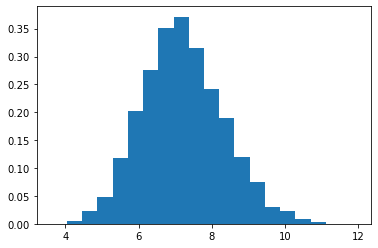

In [60]:
# set begin of chain lambda = 5
thetas = [5]
chain_len = 10000

for i in range(chain_len):
    MH_iterator(thetas)

plt.hist(thetas, bins=20, density=True)
plt.show()

## Using a pre-written package

While it's not hard to code up the most basic MCMC algorithms (you just did it!), we often rely on standard packages that have nice implementations of more advanced MCMC algorithms that employ various clever tricks. Today we'll learn to use the ``emcee`` package.

In [3]:
import emcee

We'll illustrate this by tackling the simple example of fitting a straight line. (This next example is adapted from this [excellent tutorial](https://emcee.readthedocs.io/en/stable/tutorials/line/)). Here's some pre-generated data:

In [4]:
data = np.loadtxt('straight_line.dat')
x_vals, y_vals = data
errs = np.ones_like(y_vals)

These data were generated with error bars of size $\sigma = 1$, so they look like this:

Text(0, 0.5, '$y$')

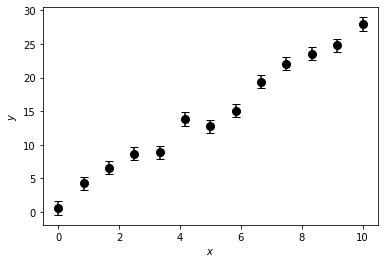

In [5]:
f, ax = plt.subplots(figsize=(6,4))
ax.errorbar(x_vals, y_vals, yerr=errs, linestyle = 'None',capsize=4, marker ='o', color='black', ms=8)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

A straight-line model for the data takes the form $y^\mathcal{M}(a, b, x) = a x + b$, so we have a two-parameter model. Our goal is to study the posterior distribution of $a$ and $b$:

\begin{equation}
p(a, b | \{ y_i \}) \propto p(\{ y_i \} | a, b) p(a,b).
\end{equation}

If we assume that the errors are Gaussian, the likelihood is given by

\begin{equation}
p(\{ y_i \} | a, b) =  \prod_{i=1}^{13} \frac{\exp\left[-\frac{\left[y_i - a x_i - b\right]^2}{2 \sigma_i^2}\right]}{\sqrt{2 \pi \sigma_i^2}}  
\end{equation}

As you probably found in Coding Lab 07, probability density functions can have incredibly large dynamic ranges (i.e., the height of the highest peak is very large compared height of the lowest point). For this reason, it is often advisable to work with the *logarithm* of probability distribution functions. This is what we must provide to ``emcee``:

In [6]:
def log_likelihood(theta, x, y, yerr):
    a, b = theta
    model = a * x + b
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2)) 
    # the 2pi factor doesn't affect the shape

We'll also need to provide a prior. We'll use a uniform prior between $-5$ and $+5$ for the intercept $b$, and a uniform prior between $-1$ and $5$ for the slope $a$:

In [7]:
def log_prior(theta):
    a, b = theta
    if -1.0 < a < 5. and -5. < b < 5.:
        return 0.0 
        # the constant doesn't matter since MCMCs only care about *ratios* of probabilities
    return -np.inf # log(0) = -inf

As always, the posterior is proportional to the likelihood multiplied by the prior:

In [8]:
def log_post(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

And now we unleash ``emcee`` and let it perform an MCMC for us!

In [9]:
num_iter = 5000
ndim = 2 # number of parameters
nwalkers = 32
initial_pos = np.array((2.6, 1.3)) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_vals, y_vals, errs))
sampler.run_mcmc(initial_pos, num_iter, progress=True);

100%|██████████| 5000/5000 [00:04<00:00, 1024.67it/s]


Let's unpack the above commands a little. The variable ``num_iter`` tells ``emcee`` how many MCMC iterations to go through, while ``ndim`` is the number of dimensions of our parameter space (here it's $2$ because we have a slope and an intercept to solve for). The ``EnsembleSampler`` is a type of MCMC that doesn't use just one walker, but instead, has a whole *ensemble* of walkers that crawl over the posterior together to "feel" its shape. Here we're using $32$ walkers. I picked the initial walker positions to be close to $(a, b) = (2.6, 1.3)$, with each walker deviating from that position by some small perturbation.

To access the MCMC chains, we type

In [10]:
samples = sampler.get_chain()

Plotting these samples gives us our trace plot, with each colour corresponding to a different walker:

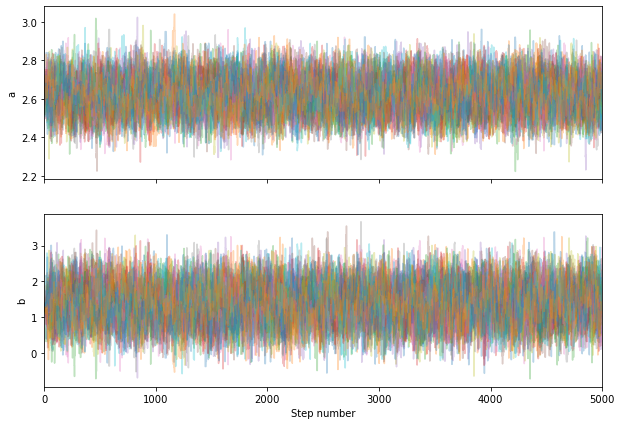

In [11]:
f, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number");

We can combine the chains from all the walkers into one chain while 1) discarding the first 100 steps as burn-in steps, and 2) thinning the chain by taking only one out of every 15 steps:

In [12]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

We can now make our corner/triangle plot to visualize our results. We've marked the median and the 16th/84th percentiles so that you can see what the 68% credibility region looks like for each parameter:

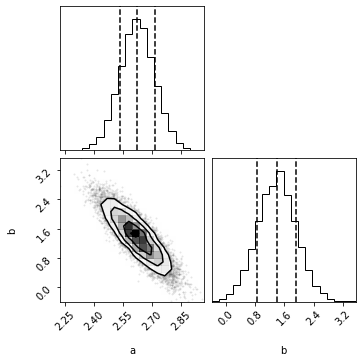

In [13]:
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

It's also helpful to take a random selection of parameter values in our chain and to plot what they look like against our data:

Text(0, 0.5, '$y$')

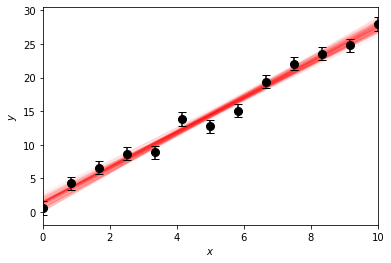

In [14]:
inds = np.random.randint(len(flat_samples), size=100)
x0 = np.linspace(0, 10., 13)
f, ax = plt.subplots(figsize=(6,4))
for ind in inds:
    sample = flat_samples[ind]
    ax.plot(x0, sample[0] * x0 + sample[1], alpha=0.05, color='red')
ax.errorbar(x_vals, y_vals, yerr=errs, linestyle = 'None',capsize=4, marker ='o', color='black', ms=8)
ax.set_xlim(0, 10.)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

The partial transparency of our best-fit lines allows us to easily see where the prediction is very tight (intense colours) and where the prediction is quite uncertain (faint colours).

## Automatic outlier detection

(The next set of exercises are adapted from the [excellent blog post](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) by Jake VanderPlas). Now suppose we had a dataset like this:

In [116]:
data2 = np.loadtxt('straight_line_outlier.dat')
x2_vals, y2_vals = data2
errs2 = np.ones_like(y2_vals)

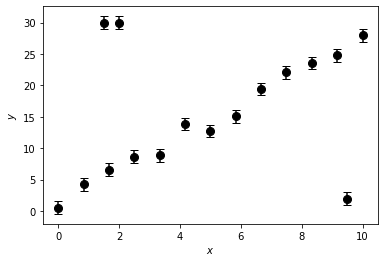

In [117]:
f, ax = plt.subplots(figsize=(6,4))
ax.errorbar(x2_vals, y2_vals, yerr=errs2, linestyle = 'None',capsize=4, marker ='o', color='black', ms=8)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$');

__Exercise__: Fit this data and plot your results. You may use an optimal linear estimator, a direct evaluation of a posterior distribution, or an MCMC.

In [151]:
# drop outlier
allow_err = 15
guess_a =  (np.max(y2_vals)-np.min(y2_vals)) / (np.max(x2_vals)-np.min(x2_vals))
guess_b = np.max(y2_vals) - np.max(x2_vals)*guess_a
for i in range(len(x2_vals)):
    diff = np.abs(y2_vals[i]-guess_a*x2_vals[i]-guess_b)
    if diff > allow_err:
        #print(diff, allow_err)
        x_new = np.delete(x2_vals, i)
        y_new = np.delete(y2_vals, i)
        err_new = np.delete(errs2, i)

In [152]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_new, y_new, err_new))
sampler2.run_mcmc(initial_pos, num_iter, progress=True);


100%|██████████| 5000/5000 [00:05<00:00, 927.06it/s] 


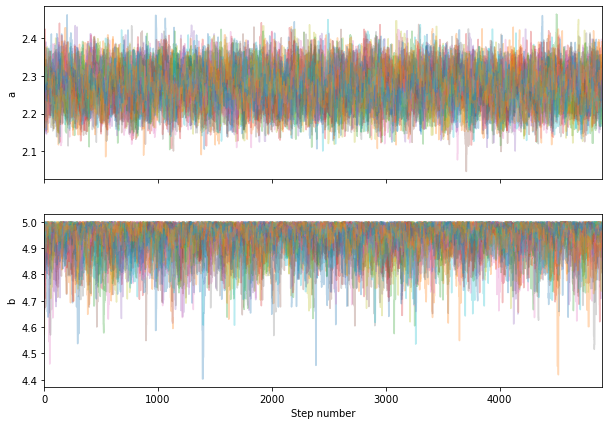

In [158]:
f, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples2 = sampler2.get_chain(discard=100)
labels = ["a", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples2[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number");

In [166]:
flat_samples2 = sampler2.get_chain(discard=100, thin=15, flat=True)

Text(0, 0.5, '$y$')

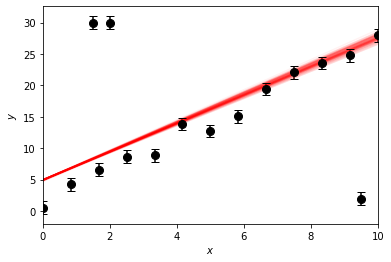

In [168]:
inds = np.random.randint(len(flat_samples2), size=100)
x0 = np.linspace(0, 10., 13)
f, ax = plt.subplots(figsize=(6,4))
for ind in inds:
    sample = flat_samples2[ind]
    ax.plot(x0, sample[0] * x0 + sample[1], alpha=0.05, color='red')
ax.errorbar(x2_vals, y2_vals, yerr=errs2, linestyle = 'None',capsize=4, marker ='o', color='black', ms=8)
ax.set_xlim(0, 10.)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

It's clear that there are three points here that are outliers that have skewed your data so that the slope is shallower than you might've expected. "Normally", one might just be tempted to throw out these data points. But this seems a little arbitrary. What if they had been a little closer to the other points? At what point do we declare that they are "far enough" to be thrown out as outliers? It turns out that a Bayesian approach allows the data to decide which datapoints are outliers.

The idea here is that just from a quick glance of the data, it's clear that a linear model doesn't fit the data. We should come up with a more general model that includes the possibility of outliers. One possible model is one where the likelihood is given by

\begin{equation}
p(\{ y_i \} | a, b, \{g_i\}, \gamma) =  \prod_{i=1}^{16} \left( \frac{g_i}{\sqrt{2 \pi \sigma_i^2}} \exp\left[-\frac{\left(y_i - a x_i - b\right)^2}{2 \sigma_i^2}\right]  + \frac{(1-g_i)}{\sqrt{2 \pi \gamma^2}} \exp\left[-\frac{\left(y_i - a x_i - b\right)^2}{2 \gamma^2}\right]\right)
\end{equation}

We now have a lot of parameters! In addition to $a$ and $b$, we now have a $g_i$ parameter associated with each data point. There's also a new parameter that we have called $\gamma$. For simplicity in this exercise we will not treat it as a free parameter, but instead we will set it to some large value $\gamma = 25$. But even with $\gamma$ fixed, we have gone from a 2-dimensional parameter space to a 18-dimensional parameter space!

The model that we have written down is one where each data point has some probability $g_i$ of being drawn from Gaussian we used before; if it isn't drawn from this distribution, it's instead drawn from a different Gaussian distribution that has standard deviation $\gamma$. Since $\gamma \gg \sigma_i$, this is a very broad distribution that accounts for the possibility that the data might be drawn from an "outlier distribution".

As usual, Bayes' theorem tells us that
\begin{equation}
p( a, b, \{g_i\}, \gamma | \{ y_i \} ) \propto p(\{ y_i \} | a, b, \{g_i\}, \gamma) p(a, b, \{g_i\}, \gamma)
\end{equation}

Once we compute the posterior distribution, we can marginalize over all the parameters except for a particular $g_i$. The resulting distribution for $g_i$ can then tell us whether we should treat a data point as an outlier or not. If $g_i$ is peaked near $1$, then the data point is probably not an outlier. If it's peaked near $0$, it's probably an outlier. In some ways, though, this is really just something that we do to satisfy our curiosity. A more direct way to fit the data is to simply marginalize over $\{ g_i \}$---which are **nuisance parameters**---leaving us with a two-dimensional posterior distribution over $a$ and $b$ like we had before.

__Exercise__: Do what I just suggested! With so many parameters, a direct plotting of the posterior is not practical; perform an MCMC sampling instead. Confirm that the three data points we intuitively thought were outliers are, in fact, outliers. Plot some representative fits to the data, showing that our new results are no longer so skewed by the outliers. (Your MCMC may take a few minutes to run)

In [181]:
def complex_likeli(thetas, x, y, errs):
    a = thetas[0]
    b = thetas[1]
    g = thetas[2:]
    gamma = 25
    result = 1

    for i in range(1,17):
        left_half = g[i] * np.exp(-(y[i]-a*x[i]-b)**2/2/errs[i]**2) / (2*np.pi*errs[i]**2)**.5
        right_half = (1-g[i]) * np.exp(-(y[i]-a*x[i]-b)**2/2/gamma**2) / (2*np.pi*gamma**2)**.5
        result *= (left_half+right_half)
    return result


def complex_prior(theta):
    g = thetas[2:]
    if np.max(g)<=1 and np.min(g)>=0:
        return 0 
    return -np.inf


def complex_post(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [182]:
num_iter = 5000
ndim = 18 # number of parameters
nwalkers = 50
start = np.ones(18)
start[0] = 2.6
start[1] = 1.3
initial_pos = start + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, complex_post, args=(x2_vals, y2_vals, errs2))
sampler.run_mcmc(initial_pos, num_iter, progress=True);

100%|██████████| 5000/5000 [01:15<00:00, 66.25it/s]


In [204]:
#f, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
'''labels = ["a", "b"]
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Step number");'''

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

sum = np.sum(flat_samples,axis=0)
outliers = np.argsort(sum)[:3]


In [196]:
'''test
a=[1,5,6,2,9,3,3,4]
np.argsort(a)[-3:]'''

array([1, 2, 4])

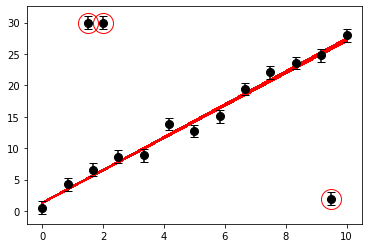

In [215]:
for i in flat_samples:
    plt.plot(x0, i[0] * x0 + i[1], alpha=0.05, color='red')
for j in outliers:
    j -= 2  # minus a and b
    plt.plot(x2_vals[j], y2_vals[j], 'ro', ms=20, mfc='none', mec='red')
plt.errorbar(x2_vals, y2_vals, yerr=errs2, linestyle = 'None',capsize=4, marker ='o', color='black', ms=8)
plt.show()

## Back to SNe Ia

Recall that way back in Coding Lab 02, we looked at how SNe Ia could be used as standard candles to constrain cosmological parameters. Let's look at that data again:

In [19]:
sn_z,sn_dm,sn_dm_err = np.loadtxt("SCPUnion2.1_mu_vs_z.txt",delimiter="\t",\
                                  skiprows=5, usecols = (1,2,3),unpack=True)

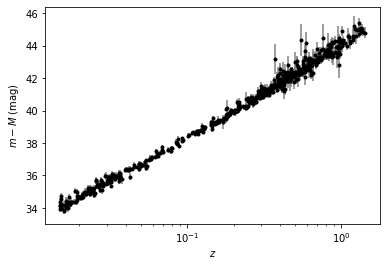

In [20]:
f, ax = plt.subplots(figsize=(6,4))
#ax[0].plot(sn_z, sn_dm, '.', color="black", label="Type Ia SNe data",alpha=0.25)
ax.errorbar(sn_z, sn_dm, yerr=sn_dm_err, fmt='.k', ecolor='gray')
ax.set_xscale('log')
ax.set_ylabel(r'$m-M$ (mag)')
ax.set_xlabel(r'$z$');

Recall from Coding Lab 02 that these data can be used to fit for $\Omega_m$ (the normalized matter density) and $\Omega_\Lambda$ (the normalized dark energy density). We didn't actually do the fit during Coding Lab 02 because I wanted to wait until we could do it in a statistically disciplined way. Which is now!

__Exercise__: Assuming Gaussian error bars, find the posterior distribution for $\Omega_m$ and $\Omega_\Lambda$. (Hint: the ``astropy`` package allows you to create ``LambdaCDM`` objects. Once these objects are supplied with a value of $H_0$, $\Omega_\Lambda$, and $\Omega_m$, the ``distmod`` function contained in the object can return the distance modulus $m-M$. Here we are only interested in $\Omega_m$ and $\Omega_\Lambda$, so what must you do with $H_0$?). 

In [21]:
## Your code here

If you compare this to Figure 6 of the seminal [Reiss et al. (1998)](https://iopscience.iop.org/article/10.1086/300499/meta) paper, you will see that the data you're using (compiled in 2011) is more constraining. The data have only improved since then. Do note, though, that the default contours drawn by the ``corner`` package do __*not*__ represent the $68\%$ and $95\%$ credibility regions. [Here's](https://corner.readthedocs.io/en/latest/pages/sigmas.html) a description of what they're plotting. I actually disagree with their philsophy of what should be the default, but there's no problem as long as we're clear about what's being plotted.

## Resources for further study

Naturally, we've only barely scratched the surface when it comes to MCMCs. But you have the basics now, enough for you to use MCMCs as a workhorse tool in your data analyses! For those who want to go a little deeper, here are some nice resources:
* [Hogg & Foreman-Mackey (2017)](https://arxiv.org/abs/1710.06068) have a really nice pedagogical treatment of MCMCs. It's written at about the same level as this class, but discusses some details that we didn't have time to cover.
* [Geyer (2011)](http://www.mcmchandbook.net/HandbookChapter1.pdf) does things a little bit more systematically, with some slightly more detailed derivations.
* [Betancourt (2019)](https://betanalpha.github.io/assets/case_studies/markov_chain_monte_carlo.html). Those who enjoy mathematical rigour but still appreciate helpful graphics for visualization will enjoy this treatment of MCMCs.
* [MacKay's Information Theory, Inference, and Learning Algorithms textbook](https://www.inference.org.uk/itprnn/book.pdf) has some delightful prose. It also explores some MCMC-alternatives.

## Submitting your work

Don't forget to push a copy of your completed notebook to your Github repo for marking!